# Linear regression for housing price prediction.

#### Below points summerizes the work carried out on this workbook.
1. Merge the additional data collected about a subset of housing data (Webscraper_for_additional_data.ipynb) with the basic information we collected (Webscraper.ipynb).
2. Data pre-processing (data cleaning, missing value handling, data type correction).
3. EDA.
    - Numerical variables (Correlation analysis, data standadization)
    - Categorical variables (Kruskal-Wallis Hypothesis test, data encoding).
4. Training linear regression models on the collected data.

#### Results

Below table summerizes the reuslts of the linear regression models trained respectively with basic and additional data.

   | | Data set  | R2 - Polynomial LR    | R2 - Multiple LR |
|---:|:-------------|:-----------|:------|
| 1 | Basic  |  0.773      |  0.763  | 
| 2 | Additional | 0.918   |  0.918  |

### 

In [710]:
import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
!#pip install pingouin
from pingouin import kruskal
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [711]:
#load housing data - Basic information - from webscraper I
df1 = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/hemnet_data.csv', delimiter=';', header=None)
df1 = df1.iloc[:,1:12]
df1.columns = ['address', 'primary_house_type', 'solddate', 'soldprice', 'asking_price', 'price_change', 'size', 'rooms', 'monthly_fee', 'agent','URL']


In [712]:
#drop any duplicate rows
df1 = df1.drop_duplicates()

In [713]:
#load municipality based information.

#Municipality based info
df1['municipality']=np.nan
#df1['school_score']=np.nan
df1['municipality_tax_rate']=np.nan


#Update municipality variable. The variable updated accordingly so that the kommune names matches with each other.
municipality_df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/municipality.csv', delimiter=';')

#These files are downloded from https://www.scb.se/en/finding-statistics/ and changed by removing unnessary columns and formattings.
tax_df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/local-tax-rates.csv', delimiter=';')

#Municipality variable of the datafile is updated accordingly so that the municipality names matches with each other.
#school_df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/school_ranking.csv', delimiter=';')
#school_df.columns = ['Rankning', 'Municipality']

for   m in  (municipality_df['Municipality']):
      
      if df1['address'].str.contains(m).shape[0] > 0:

            #extract municipality
            df1.loc[df1['address'].str.contains(m),['municipality'] ]= m

            #extract municipality tax rate
            local_tax_rate = float(tax_df[tax_df['Municipality'].str.contains(m)]['Local tax rate year 2022. municipality (%)'])
            df1.loc[df1['address'].str.contains(m),'municipality_tax_rate' ]= local_tax_rate

            #Update school district ranking 
            #try:
            #      school_rank = int(school_df[school_df['Municipality'].str.contains(m.split()[0])]['Rankning'])
            #except:
            #      k = difflib.get_close_matches(m, school_df['Municipality'] , n=1)[0]
            #      school_rank = int(school_df[school_df['Municipality'].str.contains(k)]['Rankning'])
       
            #df1.loc[df1['address'].str.contains(m),'school_score'] = school_rank

In [714]:
df1.head()

,address,primary_house_type,solddate,soldprice,asking_price,price_change,size,rooms,monthly_fee,agent,URL,municipality,municipality_tax_rate
0,"Vänortsgatan 7 D Mölndal - Bosgården, Mölndals...",Apartment,29 05 2022,1450000,1348500.0,7.0,21.0,1,1960.0,Bjurfors,https://www.hemnet.se/salda/lagenhet-1rum-moln...,Mölndals kommun,20.51
1,"Lövmånadsgatan 2 Kortedala, Göteborgs kommun",Apartment,27 05 2022,1050000,987000.0,6.0,25.0,1,1819.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-kort...,Göteborgs kommun,21.12
2,"Järnvägsgatan 22 A Ranten, Falköpings kommun",Apartment,20 05 2022,160000,164800.0,-3.0,23.5,1,1475.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-rant...,Falköpings kommun,21.95
3,"Piltegatan 5A Bosgården, Mölndals kommun",Apartment,20 05 2022,1660000,1676600.0,-1.0,25.0,1,1776.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-bosg...,Mölndals kommun,20.51
4,"Västmannagatan 11 Norrby, Borås kommun",Apartment,20 05 2022,400000,424000.0,-6.0,25.0,1,1654.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-norr...,Borås kommun,21.31


In [715]:
#load housing data - Additional information - from webscraper II
df2 = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/additional_data/data/additional_info_hosuing_data.csv', delimiter=',')
#English column names
df2.columns = ['URL','Fee/month', 'Number of rooms', 'House type','Asking price', 'Balcony', 'Living area', 'Secondary area', 'Construction year', 'Operating cost', 'Price per square meter', 'Price trend', 'Plot area', 'Letting form 1', 'Patio', 'Floor', 'Letting form 2', 'Lease', 'Association', 'Land right fee']

In [716]:
df2.head()

,URL,Fee/month,Number of rooms,House type,Asking price,Balcony,Living area,Secondary area,Construction year,Operating cost,Price per square meter,Price trend,Plot area,Letting form 1,Patio,Floor,Letting form 2,Lease,Association,Land right fee
0,https://www.hemnet.se/salda/lagenhet-1rum-moln...,1 960 kr/mån,1 rum,Lägenhet,1 350 000 kr,Nej,21 m2,NaN,1952,3 600 kr/år,69 048 kr/m2,+100 000 kr (+7 %),NaN,NaN,NaN,"3, hiss finns ej",Bostadsrätt,NaN,NaN,NaN
1,https://www.hemnet.se/salda/lagenhet-1rum-kort...,1 819 kr/mån,1 rum,Lägenhet,995 000 kr,NaN,25 m2,NaN,1955,3 000 kr/år,42 000 kr/m2,+55 000 kr (+6 %),NaN,NaN,NaN,"1 av 3, hiss finns ej",Bostadsrätt,NaN,NaN,NaN
2,https://www.hemnet.se/salda/lagenhet-1rum-rant...,1 475 kr/mån,1 rum,Lägenhet,165 000 kr,NaN,"23,5 m2",NaN,1965 - 1966,3 000 kr/år,6 809 kr/m2,-5 000 kr (-3 %),NaN,NaN,NaN,"5 av 5, hiss finns",Bostadsrätt,NaN,NaN,NaN
3,https://www.hemnet.se/salda/lagenhet-1rum-bosg...,1 776 kr/mån,1 rum,Lägenhet,1 675 000 kr,Ja,25 m2,NaN,1957,3 459 kr/år,66 400 kr/m2,-15 000 kr (-1 %),NaN,NaN,NaN,"1 av 3, hiss finns ej",Bostadsrätt,NaN,NaN,NaN
4,https://www.hemnet.se/salda/lagenhet-1rum-norr...,1 654 kr/mån,1 rum,Lägenhet,425 000 kr,Nej,25 m2,NaN,1948,3 984 kr/år,16 000 kr/m2,-25 000 kr (-6 %),NaN,NaN,NaN,"3 av 3, hiss finns ej",Bostadsrätt,NaN,NaN,NaN


In [804]:
df2.shape

(21611, 21)

### Data pre-processing

Here, we format the data as below.
- Translate any Swedish to text to English i.e., Housing type, Balcony, Letting form 2
- Remove any trailing unit infomation for Fee/month, Number of rooms, Asking price, Living area,  Operating cost, Price per square meter, Price trend	
- Split any variable that contains more than one piece of information - i.e., Floor as total floors, apartment floor, lift (yes/no).

Let's go by each variable.

In [717]:
#Variable  - Fee/month
#Update - remove triling string 'kr/man' and convert variable to float.

#remove trailing text
df2['Fee/month'] = df2['Fee/month'].str.replace('kr/mån', '')
#remove any spaces
df2['Fee/month'] = df2['Fee/month'].str.strip()
df2['Fee/month'] = df2['Fee/month'].str.replace(' ','')
#convert to float
df2['Fee/month'] = df2['Fee/month'].astype('float64')
df2['Fee/month'].head()

0    1960.0
1    1819.0
2    1475.0
3    1776.0
4    1654.0
Name: Fee/month, dtype: float64

In [718]:
#Variable  - Number of rooms
#Update - remove triling string 'rum' and replace any ',' with '.'. Finally, convert variable to float.

#remove unwanted text
df2['Number of rooms'] = df2['Number of rooms'].str.replace('rum', '')
df2['Number of rooms'] = df2['Number of rooms'].str.replace(',', '.')
#remove trailing spaces
df2['Number of rooms'] = df2['Number of rooms'].str.strip()
#convert to float
df2['Number of rooms'] = df2['Number of rooms'].astype('float64')
df2['Number of rooms'].head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Number of rooms, dtype: float64

In [719]:
#Variable  - Housing type
#Update - translate to english
df2['House type'] = df2['House type'].replace('Lägenhet','Apartment')
df2['House type'] = df2['House type'].replace('Villa','House')
df2['House type'] = df2['House type'].replace('Vinterbonat fritidshus','Holiday Home')
df2['House type'] = df2['House type'].replace('Radhus','Town House') #Also known as terrace house. But to keep align with the previous datafile of basic infomation we leave this as Townhouse
df2['House type'] = df2['House type'].replace('Parhus','Semi-detached House')
df2['House type'] = df2['House type'].replace('Gård utan jordbruk','Farm House, w/o agriculture')
df2['House type'] = df2['House type'].replace('Kedjehus','Chain house')
df2['House type'] = df2['House type'].replace('Par-/kedje-/radhus','Unspecified (Town/Semi-detached/Chain)') #We mention these as unspecified as they belong to any of the above three categories.

df2['House type'].head()

0    Apartment
1    Apartment
2    Apartment
3    Apartment
4    Apartment
Name: House type, dtype: object

In [720]:
#Variable  - Housing type
#Update - translate to english
# df2['House type'] = df2['House type'].replace('Lägenhet','Apartment')
# df2['House type'] = df2['House type'].replace('Villa','House')
# df2['House type'] = df2['House type'].replace('Vinterbonat fritidshus','House')
# df2['House type'] = df2['House type'].replace('Radhus','House') #Also known as terrace house. But to keep align with the previous datafile of basic infomation we leave this as Townhouse
# df2['House type'] = df2['House type'].replace('Parhus','House')
# df2['House type'] = df2['House type'].replace('Gård utan jordbruk','House')
# df2['House type'] = df2['House type'].replace('Kedjehus','House')
# df2['House type'] = df2['House type'].replace('Par-/kedje-/radhus','House') #We mention these as unspecified as they belong to any of the above three categories.
# df2['House type'].head()

In [721]:
#Variable  - Asking price
#Update - remove triling string 'kr',  replace any white spaces and convert to float

#remove trailing text
df2['Asking price'] = df2['Asking price'].str.replace('kr', '')
#remove any spaces
df2['Asking price'] = df2['Asking price'].str.strip()
df2['Asking price'] = df2['Asking price'].str.replace(' ','')
#convert to float
df2['Asking price'] = df2['Asking price'].astype('float64')
df2['Asking price'].head()


0    1350000.0
1     995000.0
2     165000.0
3    1675000.0
4     425000.0
Name: Asking price, dtype: float64

In [722]:
#Variable  - Balcony
#Update - Replace Ja with 1 and Nej with 0. Leave Nan as it is. 
df2['Balcony'] = df2['Balcony'].str.replace('Ja', '1')
df2['Balcony'] = df2['Balcony'].str.replace('Nej', '0')
df2['Balcony'].head()

0              0        
1                    NaN
2                    NaN
3              1        
4              0        
Name: Balcony, dtype: object

In [723]:
#Variable  - Living area
#Update - Replace trailing string 'm2' and ',' with '.'.
df2['Living area'] = df2['Living area'].str.replace('m2','')
df2['Living area'] = df2['Living area'].str.replace(',','.')

df2['Living area'] = df2['Living area'].str.strip()

#convert to float
df2['Living area'] = df2['Living area'].astype('float64')
df2['Living area'].head()

0    21.0
1    25.0
2    23.5
3    25.0
4    25.0
Name: Living area, dtype: float64

In [724]:
#Variable  - Secondary area
#Update - Replace trailing string 'm2' and ',' with '.'

df2['Secondary area'] = df2['Secondary area'].str.replace('m2','')
df2['Secondary area'] = df2['Secondary area'].str.replace(',','.')

df2['Secondary area'] = df2['Secondary area'].str.strip()

#convert to float
df2['Secondary area'] = df2['Secondary area'].astype('float64')


In [725]:
#Variable  - Construction year
#Update - Replace trailing and preceiding white spaces. For any data point where the year is mentioned as a range (e.g., 1950-1952) get the average and round to the celing value. 

df2['Construction year'] = df2['Construction year'].str.strip()

#Handle year given as a range
year =  df2['Construction year'].str.split('-')

for i in range(0,year.shape[0]):
    if year[i] is not np.nan:
        if len(year[i]) ==2:
            #df2['Construction year'][i] = int(np.ceil(( int(year[i][0]) + int(year[i][1]))/2))
            df2.loc[i, 'Construction year'] = int(np.ceil(( int(year[i][0]) + int(year[i][1]))/2))
        else: 
            #df2['Construction year'][i] = year[i][0]
            df2.loc[i, 'Construction year'] = year[i][0]


df2['Construction year'].head()

0    1952
1    1955
2    1966
3    1957
4    1948
Name: Construction year, dtype: object

In [726]:
#Variable  - Operating cost
#Update - remove triling string 'kr/år',  replace any white spaces and convert to float

#remove trailing text
df2['Operating cost'] = df2['Operating cost'].str.replace('kr/år', '')
#remove any spaces
df2['Operating cost'] = df2['Operating cost'].str.strip()
df2['Operating cost'] = df2['Operating cost'].str.replace(' ','')
#convert to float
df2['Operating cost'] = df2['Operating cost'].astype('float64')
df2['Operating cost'].head()


0    3600.0
1    3000.0
2    3000.0
3    3459.0
4    3984.0
Name: Operating cost, dtype: float64

In [727]:
#Variable  - Price per square meter

#Update - remove triling string 'kr/m2',  replace any white spaces and convert to float

#remove trailing text
df2['Price per square meter'] = df2['Price per square meter'].str.replace('kr/m2', '')
#remove any spaces
df2['Price per square meter'] = df2['Price per square meter'].str.strip()
df2['Price per square meter'] = df2['Price per square meter'].str.replace(' ','')
#convert to float
df2['Price per square meter'] = df2['Price per square meter'].astype('float64')
df2['Price per square meter'].head()


0    69048.0
1    42000.0
2     6809.0
3    66400.0
4    16000.0
Name: Price per square meter, dtype: float64

In [728]:
#We do not process price trend variable as is a duplicated one.

In [729]:
#Variable  - Operating cost
#Update - remove triling string 'm2',  replace any white spaces and convert to float

#remove trailing text
df2['Plot area'] = df2['Plot area'].str.replace('m2', '')
df2['Plot area'] = df2['Plot area'].str.replace(',', '.')

#remove any spaces
df2['Plot area'] = df2['Plot area'].str.strip()
df2['Plot area'] = df2['Plot area'].str.replace(' ','')
#convert to float
df2['Plot area'] = df2['Plot area'].astype('float64')
df2['Plot area'].head()

df2['Plot area'].unique()

array([  nan,  250., 2463., ..., 5923., 1619., 4086.])

In [730]:
#Letting form 1 variable is null for all the records. Thus will be discarded.

In [731]:

#Variable  - Patio
#Update - 

#df2['Patio'].unique()
#df2['Patio'] = df2['Patio'].str.replace('Ja','1')


In [732]:
#Variable  - Floor
#Update - The varibale contains below information
    #specific floor of the apartment
    #availability of a lift

df2['Floor'] = df2['Floor'].str.strip()

#Update infomation
df2['Lift Info'] = df2['Floor'].str.contains('hiss finns')

#extract floor number and lift availability
floor_num, lift_avail =[], []

for i in range(0,df2.shape[0]):
    if df2['Lift Info'][i] == True:

        n_terms = len(df2['Floor'][i].split(','))

        #floor info
        if n_terms == 2:
            f_info = df2['Floor'][i].split(',')[0].strip()
            f_info = f_info.split('av')[0]

            #lift
            l_info = df2['Floor'][i].split(',')[1]
        
        elif n_terms == 3:
            f_info = df2['Floor'][i].split(',')[0].strip()
            l_info = df2['Floor'][i].split(',')[2]

        #Update the lift availability
        l_info = l_info.strip()
        l_info = l_info.replace('hiss finns ej','0')
        l_info = l_info.replace('hiss finns','1')

    elif df2['Lift Info'][i] == False:
        
        if df2['Floor'][i] is not np.nan:
            #floor info
            f_info = df2['Floor'][i].split('av')[0].strip()
            l_info = '0'

    else: 
        f_info=np.nan
        l_info = np.nan

    f_info = str(f_info).replace(',','')
    floor_num.append(f_info)
    lift_avail.append(l_info)

#Add two variables
df2['Floor Number'] = pd.DataFrame(floor_num)
df2['Lift Availability'] = pd.DataFrame(lift_avail)




In [733]:
#Variable  - Letting form 2
#Update - translate to english 
    
df2['Letting form 2'] = df2['Letting form 2'].replace('Bostadsrätt','Right of residence')    
df2['Letting form 2'] = df2['Letting form 2'].replace('Annat','Other')    
df2['Letting form 2'] = df2['Letting form 2'].replace('Äganderätt','Right of ownership')    
df2['Letting form 2'] = df2['Letting form 2'].replace('Andel i bostadsförening','Share in housing association')    
df2['Letting form 2'] = df2['Letting form 2'].replace('Andelsboende','Co-operative housing')    
df2['Letting form 2'] = df2['Letting form 2'].replace('Tomträtt','Land right')    


In [734]:
#Variable  - Lease
#Update - remove 'kr/år/år' and trailing/preceding spaces
df2['Lease'] = df2['Lease'].str.replace('kr/år/år','')   
df2['Lease'] = df2['Lease'].str.replace(' ','')    
df2['Lease'] = df2['Lease'].str.strip()    


In [735]:
#Variable  - Association
#Update - remove trailing/preceding spaces

df2['Association'] = df2['Association'].str.strip()

In [736]:
#Variable  - Land right fee
#Update - remove 'kr/år/år' and trailing/preceding spaces

df2['Land right fee'] = df2['Land right fee'].str.replace('kr/år/år','')   
df2['Land right fee'] = df2['Land right fee'].str.replace(' ','')    
df2['Land right fee'] = df2['Land right fee'].str.strip()    


In [737]:
df2.drop(['Letting form 1', 'Lift Info',],axis=1,inplace=True)

In [738]:
df2.columns

Index(['URL', 'Fee/month', 'Number of rooms', 'House type', 'Asking price',
       'Balcony', 'Living area', 'Secondary area', 'Construction year',
       'Operating cost', 'Price per square meter', 'Price trend', 'Plot area',
       'Patio', 'Floor', 'Letting form 2', 'Lease', 'Association',
       'Land right fee', 'Floor Number', 'Lift Availability'],
      dtype='object')

In [739]:
#Merge basic info and additional info to a single dataframe based on URL attribute
df_full = pd.merge(df1, df2, on='URL', how='inner')


In [740]:
df_full.head()

,address,primary_house_type,solddate,soldprice,asking_price,price_change,size,rooms,monthly_fee,agent,...,Price trend,Plot area,Patio,Floor,Letting form 2,Lease,Association,Land right fee,Floor Number,Lift Availability
0,"Vänortsgatan 7 D Mölndal - Bosgården, Mölndals...",Apartment,29 05 2022,1450000,1348500.0,7.0,21.0,1,1960.0,Bjurfors,...,+100 000 kr (+7 %),NaN,NaN,"3, hiss finns ej",Right of residence,NaN,NaN,NaN,3,0
1,"Lövmånadsgatan 2 Kortedala, Göteborgs kommun",Apartment,27 05 2022,1050000,987000.0,6.0,25.0,1,1819.0,Fastighetsbyrån,...,+55 000 kr (+6 %),NaN,NaN,"1 av 3, hiss finns ej",Right of residence,NaN,NaN,NaN,1,0
2,"Järnvägsgatan 22 A Ranten, Falköpings kommun",Apartment,20 05 2022,160000,164800.0,-3.0,23.5,1,1475.0,Fastighetsbyrån,...,-5 000 kr (-3 %),NaN,NaN,"5 av 5, hiss finns",Right of residence,NaN,NaN,NaN,5,1
3,"Piltegatan 5A Bosgården, Mölndals kommun",Apartment,20 05 2022,1660000,1676600.0,-1.0,25.0,1,1776.0,HusmanHagberg,...,-15 000 kr (-1 %),NaN,NaN,"1 av 3, hiss finns ej",Right of residence,NaN,NaN,NaN,1,0
4,"Västmannagatan 11 Norrby, Borås kommun",Apartment,20 05 2022,400000,424000.0,-6.0,25.0,1,1654.0,HusmanHagberg,...,-25 000 kr (-6 %),NaN,NaN,"3 av 3, hiss finns ej",Right of residence,NaN,NaN,NaN,3,0


In [741]:
df_full.shape

(21611, 33)

In [742]:
df_full.columns

Index(['address', 'primary_house_type', 'solddate', 'soldprice',
       'asking_price', 'price_change', 'size', 'rooms', 'monthly_fee', 'agent',
       'URL', 'municipality', 'municipality_tax_rate', 'Fee/month',
       'Number of rooms', 'House type', 'Asking price', 'Balcony',
       'Living area', 'Secondary area', 'Construction year', 'Operating cost',
       'Price per square meter', 'Price trend', 'Plot area', 'Patio', 'Floor',
       'Letting form 2', 'Lease', 'Association', 'Land right fee',
       'Floor Number', 'Lift Availability'],
      dtype='object')

In [743]:
#From solddate variable we extract year and month that will help the analysis better.
df_full['year'] = pd.DatetimeIndex(df_full['solddate']).year

/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/pandas/core/indexes/datetimes.py:327: UserWarning: Parsing '29 05 2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/pandas/core/indexes/datetimes.py:327: UserWarning: Parsing '27 05 2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/pandas/core/indexes/datetimes.py:327: UserWarning: Parsing '20 05 2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  dtarr = DatetimeArray._from_sequence_not_strict(
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/pandas

In [744]:
# We drop the below variables which are either duplicates, intermediary or unnessary for modeling
#'address'/ 'URL'/ 'Association' = Additional variables collected that are not directly needed for price prediction.
#'primary_house_type', 'Fee/month', 'solddate','rooms','Price trend','asking_price','Floor' , 'Living area' - duplicates
#'Price per square meter' - can only be known after sold prioce is availabe. Hence, not excluded from prediction.
# 'price_change'-This variable is only available after doing a sale which indicates the difference between the asking price and the sold price.
df_full.drop(['address', 'primary_house_type','URL', 'Fee/month', 'solddate','rooms','Price trend','asking_price','Floor' ,'Association', 'Living area','Price per square meter', 'price_change'],axis=1,inplace=True)

In [745]:
def missing_value_computation(df):
    missing_val = {}
    for col in df.columns:
        missing_val[col] = df[col].isna().sum()/df[col].shape[0]

    missing_info = pd.DataFrame.from_dict(missing_val,orient='index').reset_index()
    missing_info.columns=['Attribute','Missing val %']
    missing_info.sort_values(by='Missing val %', inplace=True)
    return missing_info
   

In [746]:
missing_value_computation(df_full)

,Attribute,Missing val %
0,soldprice,0.000000
18,Floor Number,0.000000
15,Letting form 2,0.000000
7,House type,0.000000
5,municipality_tax_rate,0.000000
20,year,0.000000
3,agent,0.000000
1,size,0.000000
4,municipality,0.000000
6,Number of rooms,0.003979


In [747]:
df_full.rename(columns={'Letting form 2':'Letting form'}, inplace=True)


### Data types

In [748]:
df_full.dtypes

soldprice                  int64
size                     float64
monthly_fee              float64
agent                     object
municipality              object
municipality_tax_rate    float64
Number of rooms          float64
House type                object
Asking price             float64
Balcony                   object
Secondary area           float64
Construction year         object
Operating cost           float64
Plot area                float64
Patio                     object
Letting form              object
Lease                     object
Land right fee            object
Floor Number              object
Lift Availability         object
year                       int64
dtype: object

In [749]:
#Change data type to float.
df_full[['Construction year','Lease','Land right fee','Floor Number','Lift Availability', 'Balcony']] = df_full[['Construction year','Lease','Land right fee','Floor Number','Lift Availability','Balcony']].astype('float64')

In [750]:
housing_df = df_full.copy(deep=True)

<AxesSubplot:>

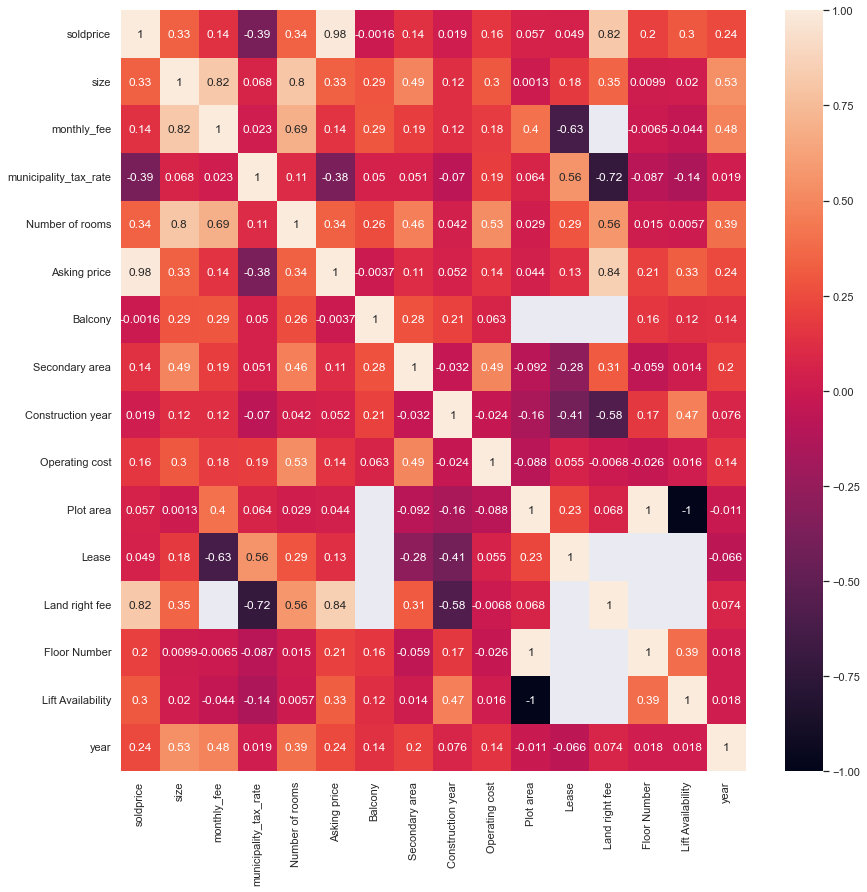

In [751]:
sns.set(rc = {'figure.figsize':(14,14)})
sns.heatmap(housing_df.corr(),annot=True)

### Missing data 

- Drop all the varaibles with over 90% of missing values. 
- Impute rest of the variables with median values - Number of rooms, Asking price, price_change, monthly_fee, Construction year, Operating cost
- Lift availability and balcony variables are inffered based on the assumption if not mentioned (i.e., missing) it is likely that the feature doesnot present.

In [752]:
missing_value_computation(housing_df)

,Attribute,Missing val %
0,soldprice,0.000000
15,Letting form,0.000000
7,House type,0.000000
5,municipality_tax_rate,0.000000
20,year,0.000000
3,agent,0.000000
1,size,0.000000
4,municipality,0.000000
6,Number of rooms,0.003979
8,Asking price,0.055944


In [753]:
#Drop variables with missing value percentage > 90%
housing_df.drop(['Patio','Plot area','Secondary area','Land right fee','Lease'], axis=1, inplace=True)

In [754]:
#Change data type to float.
housing_df[['Construction year','Floor Number','Lift Availability', 'Balcony']] = housing_df[['Construction year','Floor Number','Lift Availability','Balcony']].astype('float64')

In [755]:
#Data imputation for numeric varaibles.
housing_df['Number of rooms'].fillna(housing_df['Number of rooms'].median(), inplace = True)
housing_df['Asking price'].fillna(housing_df['Asking price'].median(),inplace=True)
#housing_df['price_change'].fillna(housing_df['price_change'].median(),inplace=True)
housing_df['monthly_fee'].fillna(housing_df['monthly_fee'].median(),inplace=True)
housing_df['Construction year'].fillna(housing_df['Construction year'].median(),inplace=True)
housing_df['Operating cost'].fillna(0,inplace=True)
housing_df['Floor Number'].fillna(housing_df['Floor Number'].median(),inplace=True)

In [756]:
#Lift availability is a binary variable. Hence, we have to take a different approach. Usually apartments are likely to have lifts rather than other property types.
#In this case all the instances which have missing 'Lift Availability' will be changed to 0 to indicate no lift is presented in the property. Given that for apartments a lift is a favourable feature 
#we make the assumption that it is unlikely that the agents would miss to update it. On the other hand for the other property types (apart from apratments) a lift is an unlikely of a feature.

housing_df['Lift Availability'].fillna(0,inplace=True)

In [757]:
#Balcony variable is imputed based on the same way as above. 
#In this case the all the instances which have missing 'Balcony' will be changed to 0 to indicate no balcony is presented in the property. 
#This is based on the assumption that, for any property type a balcony is a favourable feature. Hence, it is unlikely that the agents would miss to update its availability.

housing_df['Balcony'].fillna(0,inplace=True)

In [758]:
housing_df.columns

Index(['soldprice', 'size', 'monthly_fee', 'agent', 'municipality',
       'municipality_tax_rate', 'Number of rooms', 'House type',
       'Asking price', 'Balcony', 'Construction year', 'Operating cost',
       'Letting form', 'Floor Number', 'Lift Availability', 'year'],
      dtype='object')

### Numerical variables.

Text(0.5, 1.0, 'year')

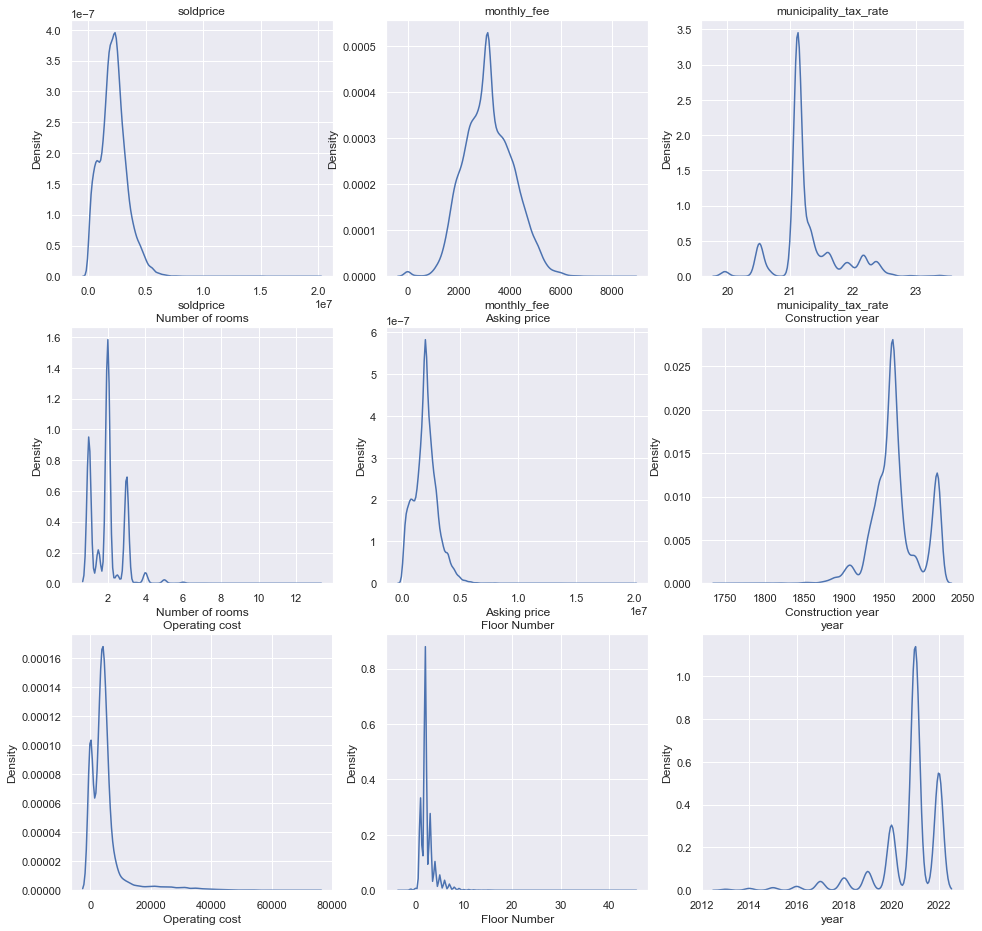

In [759]:
sns.set(rc = {'figure.figsize':(16,16)})
fig, axes = plt.subplots(3, 3)

sns.kdeplot(ax=axes[0, 0],data=housing_df['soldprice']).set_title('soldprice')
sns.kdeplot(ax=axes[0, 1],data=housing_df['monthly_fee']).set_title('monthly_fee')
sns.kdeplot(ax=axes[0, 2],data=housing_df['municipality_tax_rate']).set_title('municipality_tax_rate')
sns.kdeplot(ax=axes[1, 0],data=housing_df['Number of rooms']).set_title('Number of rooms')
sns.kdeplot(ax=axes[1, 1],data=housing_df['Asking price']).set_title('Asking price')
sns.kdeplot(ax=axes[1, 2],data=housing_df['Construction year']).set_title('Construction year')
sns.kdeplot(ax=axes[2, 0],data=housing_df['Operating cost']).set_title('Operating cost')
sns.kdeplot(ax=axes[2, 1],data=housing_df['Floor Number']).set_title('Floor Number')
sns.kdeplot(ax=axes[2, 2],data=housing_df['year']).set_title('year')

<AxesSubplot:>

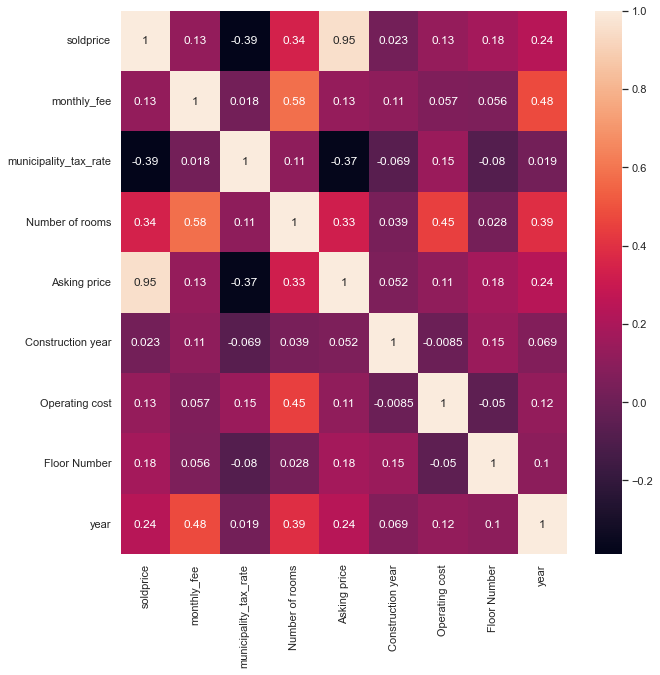

In [760]:
quantitative = ['soldprice', 'monthly_fee', 'municipality_tax_rate', 'Number of rooms', 'Asking price',  'Construction year', 'Operating cost', 'Floor Number',  'year']
       
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(housing_df[quantitative].corr(),annot=True)

Here, we can notice the following relationships with the independent and the dependent variable (sold price).
- Asking price has a strong positive correlation with the sold price.
- Price chnage has a neglegible correlation with any of the other variables.
- Monthly fee has a moderate positive relationship with number of rooms and year of sale.
- Size has a strong positive correlation with monthly fee and number of rooms.
- Municipality tax rates are negatively correlated with sold price and asking price.
- Operating cost has  a moderately postive correlation with number of rooms.
- Year has a moderately postive correlation with size,  monthly fee, and number of rooms.

Multicollinearity among the independednt variables.
- Size variale has a strong positive correlation with monthly fee and number of rooms (>0.8). Hence we are going to drop the size variable.


From the rest of the independent variables price change and construction year have neglegible correlations.


In [765]:
housing_df.drop(['size'],axis=1, inplace=True)

### Categrical variables.

In this case we vizualize the distribution of each categorical variable with respect to the sold price.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/seaborn/distributions.py:316

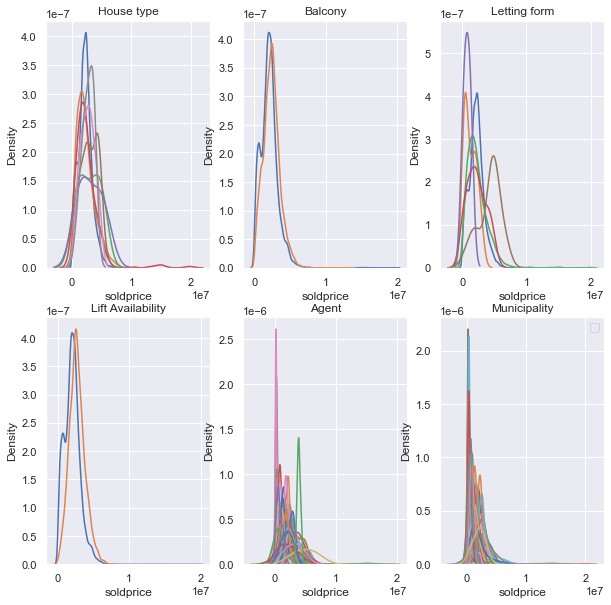

In [766]:
sns.set(rc = {'figure.figsize':(10,10)})
fig, axes = plt.subplots(2, 3)

for i, h in enumerate( housing_df['House type'].unique()):
    filter_data = housing_df[housing_df['House type']==h]['soldprice']
    sns.kdeplot(ax=axes[0, 0],data=filter_data, label = h).set_title('House type')
plt.legend()

for i, h in enumerate( housing_df['Balcony'].unique()):
    filter_data = housing_df[housing_df['Balcony']==h]['soldprice']
    
    sns.kdeplot(ax=axes[0, 1],data=filter_data, label = h).set_title('Balcony')
plt.legend()

for i, h in enumerate( housing_df['Letting form'].unique()):
    filter_data = housing_df[housing_df['Letting form']==h]['soldprice']
    
    sns.kdeplot(ax=axes[0, 2],data=filter_data, label = h).set_title('Letting form')
plt.legend()


for i, h in enumerate( housing_df['Lift Availability'].unique()):
    filter_data = housing_df[housing_df['Lift Availability']==h]['soldprice']
    
    sns.kdeplot(ax=axes[1, 0],data=filter_data, label = h).set_title('Lift Availability')
plt.legend()

for i, h in enumerate( housing_df['agent'].unique()):
    filter_data = housing_df[housing_df['agent']==h]['soldprice']
    
    sns.kdeplot(ax=axes[1, 1],data=filter_data, label = h).set_title('Agent')

for i, h in enumerate( housing_df['municipality'].unique()):
    filter_data = housing_df[housing_df['municipality']==h]['soldprice']
    
    sns.kdeplot(ax=axes[1, 2],data=filter_data, label = h).set_title('Municipality')

When considering the above distributions we can notice that in most of the cases the mean sold prices change for each variable category is different. 

#### Association between the continous target variable and the categorical independent variables

In this part we are looking into the association between the target variable (continous) and the independent (categorical) variables. Since they are respectively continous and categorical we cannot use methods like correlation or Cramer's V to quantify their relationships. Hence, we use Kruskal-Wallis Hypothesis test. This is a non-parametric test that does not make any assumption on the population distribution and can be used to indicate whether a statistically significant relationship exists between the variables of different types (categorical and numerical). 

#### Kruskal-Wallis Hypothesis test
- H0 - median sale prices are the same for all the groups.
- H1 - median sale prices are not equal for all the groups.

Here, the variable soldprice is grouped by the categories of the respective categorical variables.

If the p-val is < 0.05 we reject H0.

In [767]:
qualitative = ['agent', 'municipality', 'House type', 'Balcony', 'Letting form', 'Lift Availability']

for var in qualitative:
    kr_res = kruskal(housing_df, dv='soldprice', between=var)
    print(pd.DataFrame(kr_res),"\n")

        Source  ddof1           H  p-unc
Kruskal  agent     62  6017.75942    0.0 

               Source  ddof1             H  p-unc
Kruskal  municipality     48  10346.324236    0.0 

             Source  ddof1          H         p-unc
Kruskal  House type      7  42.168254  4.826089e-07 

          Source  ddof1           H          p-unc
Kruskal  Balcony      1  531.862926  1.110863e-117 

               Source  ddof1          H         p-unc
Kruskal  Letting form      5  62.777464  3.237094e-12 

                    Source  ddof1            H  p-unc
Kruskal  Lift Availability      1  1687.418287    0.0 



The the corresponding p-values with respct to all the categorical variables are less than 0.05. Hence, we reject the null hypothesis that the median sale prices are the same for all the groups with respect to Agent, Municipality, House type, Letting form, Balcony, and Lift availability. Hence, we can claim that the above variables lead to statistically significant differences in the median sale prices of the properties. 

### Encode categorical variables

In [768]:
#ordinal encoder
from sklearn.preprocessing import OrdinalEncoder

ord_df = housing_df.copy(deep=True)


ord_encoded = OrdinalEncoder()
ord_df[qualitative] = ord_encoded.fit_transform(ord_df[qualitative])
ord_df.head()

,soldprice,monthly_fee,agent,municipality,municipality_tax_rate,Number of rooms,House type,Asking price,Balcony,Construction year,Operating cost,Letting form,Floor Number,Lift Availability,year
0,1450000,1960.0,5.0,26.0,20.51,1.0,0.0,1350000.0,0.0,1952.0,3600.0,4.0,3.0,0.0,2022
1,1050000,1819.0,20.0,11.0,21.12,1.0,0.0,995000.0,0.0,1955.0,3000.0,4.0,1.0,0.0,2022
2,160000,1475.0,20.0,7.0,21.95,1.0,0.0,165000.0,0.0,1966.0,3000.0,4.0,5.0,1.0,2022
3,1660000,1776.0,29.0,26.0,20.51,1.0,0.0,1675000.0,1.0,1957.0,3459.0,4.0,1.0,0.0,2022
4,400000,1654.0,29.0,4.0,21.31,1.0,0.0,425000.0,0.0,1948.0,3984.0,4.0,3.0,0.0,2022


In [769]:
# for j in sorted(housing_df['municipality'].unique()):
   # idx_vals = np.array(housing_df[housing_df['municipality']==j].index.tolist())
   # encoded_val = ord_df.iloc[idx_vals]['municipality_tax_rate'].unique()[0]
   #print(j, "-" ,encoded_val)
   # print("dict_t[\""+str(j)+"\"]="+str(encoded_val)+";")
   #print(dict["Right of residence"]=4;)



### Linear regression for housing price prediction

- We implement both multiple linear regression and polynomial linear regression models.

In [791]:
from sklearn.preprocessing import StandardScaler


def create_LR_model (independent_var, target_var, quantitative_var, df, lr_type, request_train_test_data=None):
    
    #Independednt and target variables
    X=df[independent_var]

    y=df[target_var]

    #Split training and test data
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=40)

    OX_train, OX_test, Oy_train, Oy_test = X_train, X_test, y_train, y_test

    scaler = StandardScaler()
    X_train[quantitative_var] = scaler.fit_transform(X_train[quantitative_var])

    scaler = StandardScaler()
    X_test[quantitative_var] = scaler.fit_transform(X_test[quantitative_var])

    X_train=np.array(X_train)
    X_test=np.array(X_test)
    y_train=np.array(y_train)
    y_test=np.array(y_test)



    #qt = QuantileTransformer(n_quantiles=5000, output_distribution='normal',random_state=0)
    #y_train = qt.fit_transform(y_train)


    if lr_type != 'None':

        if lr_type == 'mlm':
            print("----- Multiple linear regression -----")
            lm = make_pipeline(LinearRegression())
            lcv = cross_validate(lm, X_train, y_train,
            cv=10, scoring=["neg_mean_squared_error",'r2'],
            return_train_score=True,
            return_estimator=True)

            lm.fit(X_train, y_train)



        elif lr_type == 'plm':
            print("\n----- Polinomial linear regression -----")

            #Polynomial linaer regression wirh cross validation
            lm = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
            lcv = cross_validate(lm, X_train, y_train,
            cv=10, scoring=["neg_mean_squared_error",'r2'],
            return_train_score=True,
            return_estimator=True)

            lm.fit(X_train, y_train)


        #Training accuracy
        print("Mean squared error for training data: ",-lcv['test_neg_mean_squared_error'].mean(), "±", -lcv['test_neg_mean_squared_error'].std())
        print("R squared for training data: ",lcv['test_r2'].mean(), "±", lcv['test_r2'].std(),"\n")
    
        #Test accuracy
        #predictions on test   data
        y_pred_mcv = lm.predict(X_test)
        multi_mse = mean_squared_error(y_test.ravel(), y_pred_mcv.ravel())
        multi_r2 = r2_score(y_test.ravel(), y_pred_mcv.ravel())
        print("Mean squared error for test data: ",multi_mse)
        print("R squared  for test data: ",multi_r2)

        return lm
    
    else:
        if request_train_test_data == 'Original':
            return OX_train, OX_test, Oy_train, Oy_test
        elif request_train_test_data == 'Scaled':
            return X_train, X_test, y_train, y_test

#### Prediction for buyers 

- We can see that the asking price and the sold price variables have a very strong positive correlation with each other (0.95). This is expected as the asking price is more likely to represent the the situation of the housing market at a given point of time. Moreover, the real state agents who helps to decides the asking price have a fair undestanding on the market so that they can come up with a good estimate. Hence, it is not very common for the sold price to be significantly deviated from the asking price. 
- From buyers point of view for any property the asking price variable will be available. Hence, we first build the linear regression models with the asking price varaible included.

In [792]:
#Independednt and target variables
independent_var = [ 'Asking price', 'monthly_fee', 'agent', 'municipality','municipality_tax_rate', 'Number of rooms', 'House type','Balcony', 'Construction year', 'Operating cost','Letting form', 'Floor Number', 'Lift Availability', 'year']

target_var = ['soldprice']

quantitative_var = [ 'Asking price', 'monthly_fee', 'municipality_tax_rate', 'Number of rooms',  'Construction year', 'Operating cost', 'Floor Number',  'year']

_= create_LR_model (independent_var, target_var, quantitative_var, ord_df, lr_type='mlm')

_ = create_LR_model (independent_var, target_var, quantitative_var, ord_df, lr_type='plm')



----- Multiple linear regression -----
Mean squared error for training data:  117332981099.07153 ± -13966346202.19449
R squared for training data:  0.9122093690853198 ± 0.010503569641992701 

Mean squared error for test data:  119467624125.0759
R squared  for test data:  0.9125204798997801

----- Polinomial linear regression -----
Mean squared error for training data:  114178407465.81482 ± -11191760315.813463
R squared for training data:  0.9145708050799619 ± 0.008396046458765414 

Mean squared error for test data:  111922393311.21542
R squared  for test data:  0.9180454342585516


With respect to both training and test data we can see a R2 value of 0.91 which indicates that both models are a great fit for the data we have. However, polynomial regression has a slightly higher R2 value and a lower MSE. Hence, we select polynomial regression for further improvement.

In [795]:
lr_model =create_LR_model (independent_var, target_var, quantitative_var, ord_df, lr_type='plm')



----- Polinomial linear regression -----
Mean squared error for training data:  114178407465.81482 ± -11191760315.813463
R squared for training data:  0.9145708050799619 ± 0.008396046458765414 

Mean squared error for test data:  111922393311.21542
R squared  for test data:  0.9180454342585516


In [796]:
#random feature set test
feat_list= np.array([-4.04672256e-01, -5.04578857e-01,  5.70000000e+01,  2.40000000e+01,
   2.84043772e+00,  2.75714739e-02,  0.00000000e+00,  0.00000000e+00,
  -1.32651175e-01, -6.97761740e-01,  4.00000000e+00, -8.66041176e-01,
   1.00000000e+00,  9.39450203e-01]).reshape(1, -1) 
lr_model.predict(feat_list)

array([[1676236.82882234]])

In [780]:
#save the model model
import joblib
import pickle

#Python Pickle module is used for serializing and de-serializing Python object structures(list, dict, etc.) into byte streams (0s and 1s). 
pickle_out = open("lr_predictor.pkl", "wb")
pickle.dump(lr_model, pickle_out)
pickle_out.close()



In [797]:
#For numerical data standadization after model deployment, extract the mean and the standard deviation of each variable based on the original training data.

X_train, X_test, y_train, y_test = create_LR_model (independent_var, target_var, quantitative_var, ord_df, lr_type='None', request_train_test_data='Original')

In [802]:
#convert training data to a df 
df_tmp = pd.DataFrame(X_train)
df_tmp.columns = independent_var

#Extract mean and sd for numerical variables
mean_and_sd_data = {}
for col in df_tmp.columns:
    if col in quantitative_var:
        mean_and_sd_data[col] = [np.mean(ord_df[col]), np.std(ord_df[col])]

#save to a json file
import json
with open("mean_sd.json", "w") as outfile:
    json.dump(mean_and_sd_data, outfile)
